# Data Analysis

In accordance with Karpathy, the data analysis process involves three essential steps. Firstly, visually inspect the data to ensure its quality and identify any patterns or anomalies. Next, acquire a qualitative understanding of the dataset to comprehend its inherent characteristics. Finally, conduct a quantitative analysis using code to extract meaningful insights and draw conclusions based on numerical measures. These sequential steps provide a comprehensive approach to extracting valuable information from the data.

In the following, we explore the ZüriCrop dataset using PyTorch to enhance our understanding of the data and gain insights that may be valuable for interpreting our models.

## Imports and Functions

In the following section, we begin by importing necessary libraries and defining functions for the Exploratory Data Analysis (EDA).


In [1]:
import os
print(os.getcwd())
if os.getcwd().endswith("eda"):
    os.chdir("..")

from src.modelling import DeepModel_Trainer
import torch.utils.data
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import colors


plt.rcParams["figure.figsize"] = (12,6)
pd.set_option('display.colheader_justify', 'center')

c:\Users\Tom\OneDrive\Dokumente\Github\dlbs-crop-segmentation\eda


In [2]:
file_name_zueri = r'C:\Users\danie\Documents\Studium\GitLab\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'
file_name_zueri = r'D:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'
# set random state
random_state = 123
np.random.seed(random_state)

def load_data_train(model_trainer,eval_mode=False):
    # Initialize an empty list to store batches
    all_data_input = []
    all_data_target = []
    all_data_field_instance = []
    # Iterate through the DataLoader
    for batch in model_trainer.train_loader:
        if eval_mode:
            input, _, target_2, _, gt_instance = batch
            all_data_input.append(input)
            all_data_target.append(target_2)
            all_data_field_instance.append(gt_instance)
        else:
            input, _, target_2, _ = batch
            all_data_input.append(input)
            all_data_target.append(target_2)

    # Concatenate all batches into a single tensor along the batch dimension (dim=0)
    input_train = torch.cat(all_data_input, dim=0)
    target_train = torch.cat(all_data_target, dim=0)
    if eval_mode:
        field_instance_train = torch.cat(all_data_field_instance, dim=0)
        return input_train,target_train,field_instance_train
    return input_train,target_train

def load_data_test(model_trainer):
    #     # Initialize an empty list to store batches
    all_data_input = []
    all_data_target = []
    # Iterate through the DataLoader
    for batch in model_trainer.test_loader:
        input, _, target_2, _ = batch

        all_data_input.append(input)
        all_data_target.append(target_2)

    # Concatenate all batches into a single tensor along the batch dimension (dim=0)
    input_test = torch.cat(all_data_input, dim=0)
    target_test= torch.cat(all_data_target, dim=0)
    return input_test,target_test

def prepare_data_fold(input,target):
    reshape_factor = len(input) // 10 
    input= input[0:reshape_factor*10]
    target = target[0:reshape_factor*10]
    reshaped_tensor = input.reshape(24*reshape_factor, 24*10, 4)
    reshaped_target = target.reshape(24*reshape_factor, 24*10)

    return reshaped_tensor,reshaped_target

In [3]:
# create dataloaders
trainer = DeepModel_Trainer(file_name_zueri, 'labels.csv', None, 'cpu',temporal_sampling=True)
trainer.create_loader()
input_train,target_train = load_data_train(trainer)
_, reshaped_target_train = prepare_data_fold(input_train,target_train)
input_test,target_test= load_data_test(trainer)
_, reshaped_target_test = prepare_data_fold(input_test,target_test)

5fold:  3   Mode:  test
Dataset size:  27977
Valid dataset size:  4477
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20
5fold:  4   Mode:  test
Dataset size:  27977
Valid dataset size:  1119
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20


## Map of Dataset
We used a reduced dataset from the full ZueriCrop dataset for DLBS. We have 4477 images in the trainset (red) and 1119 images in the testset (orange). We have 6 classes / labels and for each image a spatial size of 24 x 24 pixels where each pixel represents an area of 10m x 10m.

![zueri_crop reduced](assets/zueri_crop.PNG)

# Labels and Fields

In this section, our focus shifts to exploring the distributions of labels and fields. We aim to analyze the spread and patterns within these variables, shedding light on their statistical characteristics.


## Visualizing Label Distributions in Training and Testing Sets

This code generates a set of subplots to visualize the distribution of labels in both the training and testing sets. The first two subplots display the absolute frequency of each label, while the third subplot presents the relative distribution as a percentage.


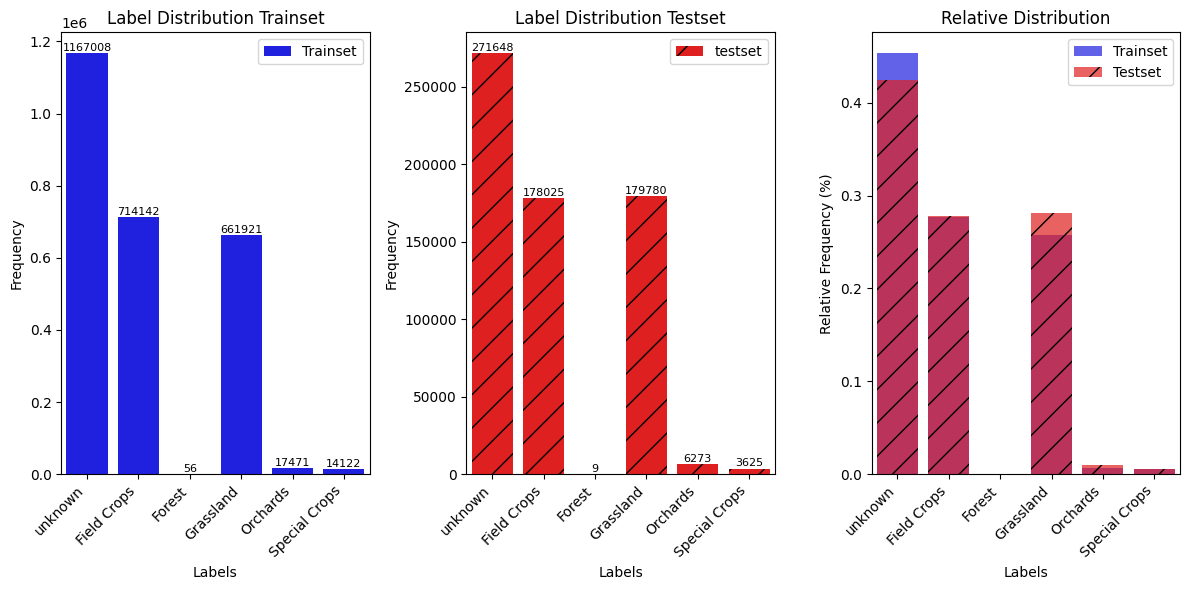

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    # Plot 1
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, index 1
    x_values_train, y_values_train = reshaped_target_train.flatten().unique(return_counts=True)
    x_np_train = x_values_train.numpy()
    y_np_train = y_values_train.numpy()
    value_labels_level_1 = ['unknown', 'Field Crops', 'Forest', 'Grassland', 'Orchards', 'Special Crops']
    ax_train = sns.barplot(x=x_np_train, y=y_np_train,color='blue',label='Trainset',)

    # Add value labels to the bars
    for i, v in enumerate(y_np_train):
        ax_train.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=8)

    # Set plot labels and title
    plt.title('Label Distribution Trainset')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    ax_train.set_xticklabels(value_labels_level_1)
    plt.xticks(rotation=45, ha='right')

    # Plot 2
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, index 2
    x_values_test, y_values_test = reshaped_target_test.flatten().unique(return_counts=True)
    x_np_test = x_values_test.numpy()
    y_np_test = y_values_test.numpy()

    # Create a bar plot using Seaborn
    ax_test = sns.barplot(x=x_np_test, y=y_np_test,color='red',hatch='/',label='testset',)

    # Add value labels to the bars
    for i, v in enumerate(y_np_test):
        ax_test.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=8)

    # Set plot labels and title
    plt.title('Label Distribution Testset')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    ax_test.set_xticklabels(value_labels_level_1)
    plt.xticks(rotation=45, ha='right')

    # Plot 3 - Relative Distribution
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, index 3
    relative_distribution_train = y_np_train / y_np_train.sum()
    relative_distribution_test = y_np_test / y_np_test.sum()

    ax_relative = sns.barplot(x=x_np_train, y=relative_distribution_train, color='blue',alpha=0.7, label='Trainset',hatch='')
    ax_relative = sns.barplot(x=x_np_test, y=relative_distribution_test, color='red',alpha=0.7, label='Testset',hatch='/')

    # Set plot labels and title
    plt.title('Relative Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Relative Frequency (%)')
    ax_relative.set_xticklabels(value_labels_level_1)
    plt.xticks(rotation=45, ha='right')

    # Add legend
    plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()



 Additionally, the same plot but removed the "unknown" class for a more focused analysis in the second set of subplots.

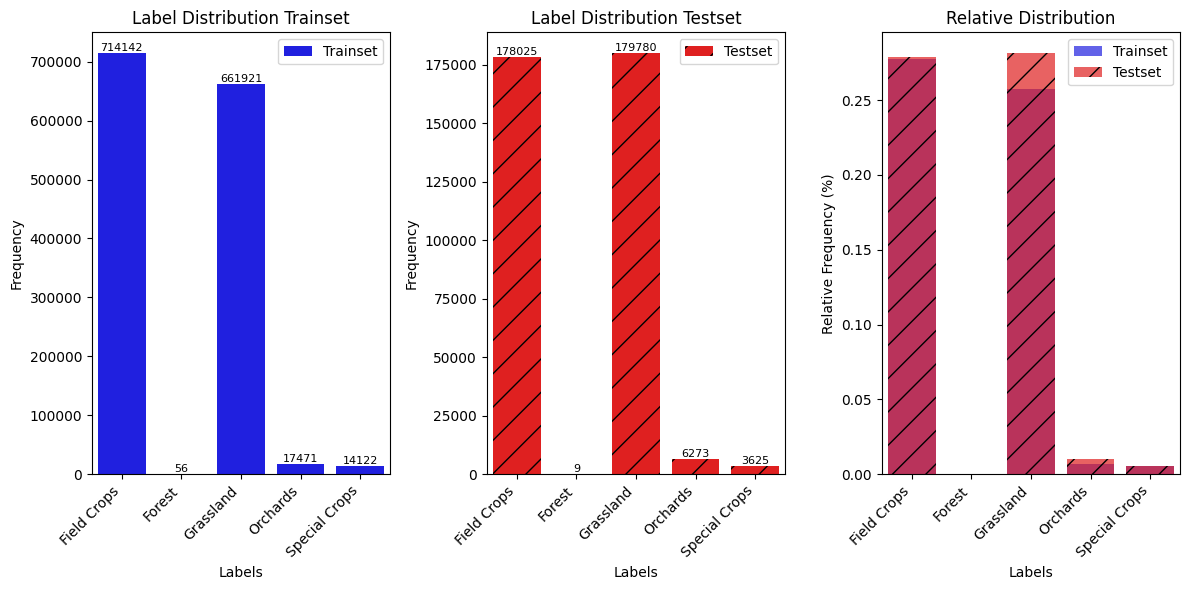

In [5]:

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    
    # Remove "unknown" label
    unknown_index = value_labels_level_1.index('unknown')
    value_labels_level_1_unknown = [label for i, label in enumerate(value_labels_level_1) if i != unknown_index]

    # Plot 1
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, index 1
    x_values_train, y_values_train = reshaped_target_train.flatten().unique(return_counts=True)
    x_np_train = x_values_train.numpy()[1:]  # Exclude "unknown" label
    y_np_train = y_values_train.numpy()[1:]  # Exclude "unknown" label
    ax_train = sns.barplot(x=x_np_train, y=y_np_train, color='blue', label='Trainset')

    # Add value labels to the bars
    for i, v in enumerate(y_np_train):
        ax_train.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=8)

    # Set plot labels and title
    plt.title('Label Distribution Trainset')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    ax_train.set_xticklabels(value_labels_level_1_unknown)
    plt.xticks(rotation=45, ha='right')

    # Plot 2
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, index 2
    x_values_test, y_values_test = reshaped_target_test.flatten().unique(return_counts=True)
    x_np_test = x_values_test.numpy()[1:]  # Exclude "unknown" label
    y_np_test = y_values_test.numpy()[1:]  # Exclude "unknown" label

    # Create a bar plot using Seaborn
    ax_test = sns.barplot(x=x_np_test, y=y_np_test, color='red', hatch='/', label='Testset')

    # Add value labels to the bars
    for i, v in enumerate(y_np_test):
        ax_test.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=8)

    # Set plot labels and title
    plt.title('Label Distribution Testset')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    ax_test.set_xticklabels(value_labels_level_1_unknown)
    plt.xticks(rotation=45, ha='right')

    # Plot 3 - Relative Distribution
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, index 3
    bar_width = 0.35
    index = np.arange(len(value_labels_level_1_unknown))

    ax_relative = sns.barplot(x=x_np_train, y=relative_distribution_train[1:], color='blue',alpha=0.7, label='Trainset',hatch='')
    ax_relative = sns.barplot(x=x_np_test, y=relative_distribution_test[1:], color='red',alpha=0.7, label='Testset',hatch='/')


    # Set plot labels and title
    plt.title('Relative Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Relative Frequency (%)')
    ax_relative.set_xticks(index)
    ax_relative.set_xticklabels(value_labels_level_1_unknown)
    plt.xticks(rotation=45, ha='right')

    # Add legend
    plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

The two figures illustrate that the classes are highly imbalanced, with *Field Crops* and *Grassland* being prominently represented. However, the most prevalent class consists of unknowns, which corresponds to streets, houses, or similar entities. 

Regardless of whether the datasets are analyzed with or without the "unknown" label, the distribution of labels in both the training and testing splits remains very similar.

## Analyzing Labels Assigned to Fields

This code segment loads training data, flattens target and field instance tensors, and creates a DataFrame to examine the relationships between targets and field instances. By grouping and counting occurrences, it identifies fields with two or more labels assigned, providing insights into label assignments for each field in the dataset.


In [6]:
# Create DataLoader in evaluation mode
trainer.create_loader(eval_mode=True)

# Load training data including input, target, and field instances
input_train, target_train, field_instance_train = load_data_train(
    trainer, eval_mode=True)

# Flatten target and field instance tensors and convert them to NumPy arrays
target_train_array = target_train.flatten().numpy()
field_instance_train_array = field_instance_train.flatten().numpy()

# Create a DataFrame to analyze the relationships between targets and field instances
df = pd.DataFrame({
    'Target': target_train_array,
    'Field_Instance': field_instance_train_array
})

# Group by 'Target' and count the occurrences of each 'Field_Instance'
value_counts_per_target = df.groupby('Target')['Field_Instance'].value_counts()

# Convert the Series to a DataFrame
result_df = value_counts_per_target.reset_index(name='Count')

# Pivot the DataFrame to have 'Field_Instance' values as columns, filling NaN with 0
pivot_df = result_df.pivot(
    index='Target', columns='Field_Instance', values='Count').fillna(0)

# Get row indexes per column where the value is not 0
indexes_not_zero = {}
for col in pivot_df.columns[1:]:
    non_zero_rows = pivot_df.index[pivot_df[col] != 0].tolist()
    indexes_not_zero[col] = non_zero_rows

# Filter columns where there are 2 or more labels assigned to a field
keys_longer_than_one = {key: value for key,
                        value in indexes_not_zero.items() if len(value) > 1}

# Print the number of fields with 2 or more labels assigned
print(
    f"There are {len([col for col, _ in keys_longer_than_one.items()])} Fields which have 2 or more labels assigned.")


5fold:  3   Mode:  test
Dataset size:  27977
Valid dataset size:  4477
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20
5fold:  4   Mode:  test
Dataset size:  27977
Valid dataset size:  1119
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20
There are 5789 Fields which have 2 or more labels assigned.


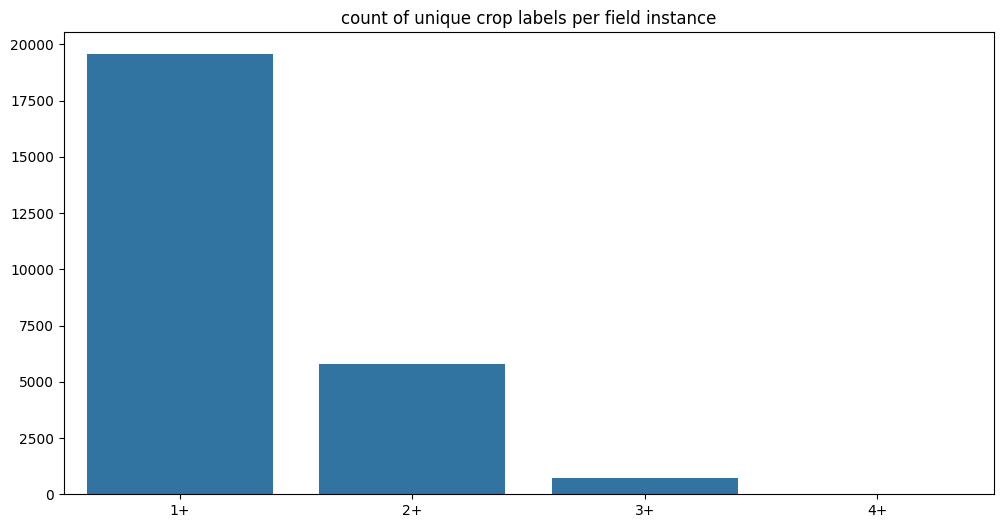

In [7]:
# Filter columns where there are i or more labels assigned to a field
keys_longer = []
for i in range(1,5):
    keys_longer.append(len([col for col, _ in {key: value for key,value in indexes_not_zero.items() if len(value) >= i}.items()]))

sns.barplot(keys_longer)
plt.title('count of unique crop labels per field instance')
plt.xticks(ticks=[0,1,2,3],labels=['1+','2+','3+','4+'])
plt.show()

There are 26'094 field instances in the train dataset and surprisingly more then 5'700 of them have more then two target classes. So each pixel has a target class, but the field_instance is not perfectly mapped on the target pixels. This could worsen the performance if we use a field majority.

# RGB-NIR Color Channel Analysis

This code visualizes the kernel density estimates for the distributions of RGB-NIR color channels in satellite imagery. The left subplot represents the overall distribution across the full training dataset, while the right subplot showcases the distribution in a random subset of the data. The analysis aids in understanding the variations in color channel values, essential for interpreting and processing satellite imagery.


5fold:  3   Mode:  test
Dataset size:  27977
Valid dataset size:  4477
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20
5fold:  4   Mode:  test
Dataset size:  27977
Valid dataset size:  1119
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20


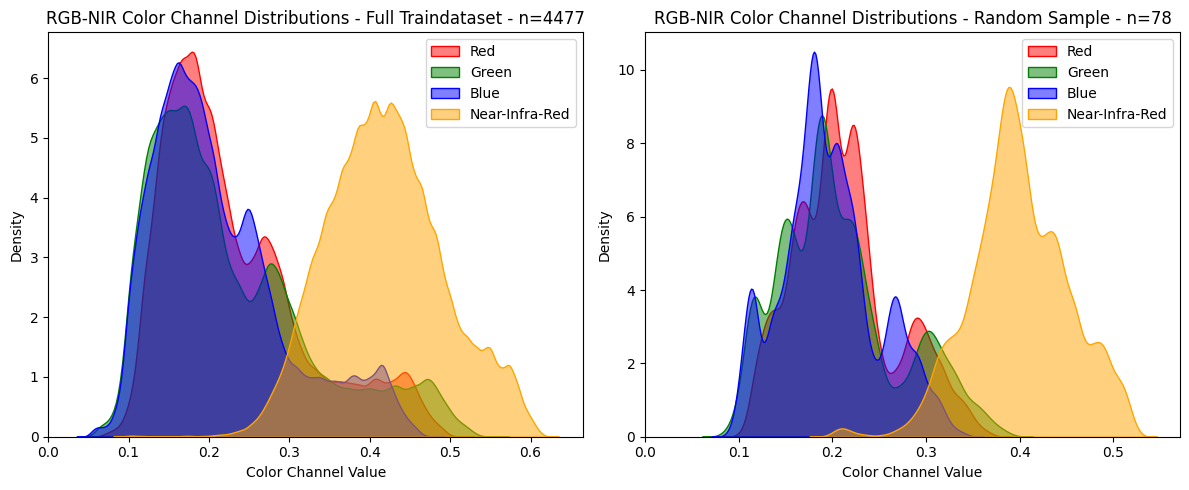

In [8]:
# Initialize a DeepModel_Trainer instance for evaluation
trainer = DeepModel_Trainer(file_name_zueri, 'labels.csv', None, 'cpu', temporal_sampling=True)

# Create data loader for evaluation mode
trainer.create_loader(eval_mode=True)

# Load evaluation data (input images, target labels, and field instances)
input_train, target_train, field_instance_train = load_data_train(trainer, eval_mode=True)

# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(12, 5))

# Plot 1 - Overall Distribution
plt.subplot(1, 2, 1)
# Plot kernel density estimates for each color channel (Red, Green, Blue, Near-Infra-Red)
sns.kdeplot(input_train[:, :, 1, :, :].flatten().numpy(), color="red", fill=True, label="Red", alpha=0.5)
sns.kdeplot(input_train[:, :, 2, :, :].flatten().numpy(), color="green", fill=True, label="Green", alpha=0.5)
sns.kdeplot(input_train[:, :, 3, :, :].flatten().numpy(), color="blue", fill=True, label="Blue", alpha=0.5)
sns.kdeplot(input_train[:, :, 0, :, :].flatten().numpy(), color="orange", fill=True, label="Near-Infra-Red", alpha=0.5)
plt.legend()
plt.title(f'RGB-NIR Color Channel Distributions - Full Traindataset - n={input_train.shape[0]}')
plt.xlabel('Color Channel Value')
plt.xlim(0)

# Plot 2 - Sample Distribution
plt.subplot(1, 2, 2)
# Select a subset of the data for a random sample
input_train_sample = input_train[1872:1950]
# Plot kernel density estimates for each color channel in the random sample
sns.kdeplot(input_train[1872:1950, :, 1, :, :].flatten().numpy(), color="red", fill=True, label="Red", alpha=0.5)
sns.kdeplot(input_train[1872:1950, :, 2, :, :].flatten().numpy(), color="green", fill=True, label="Green", alpha=0.5)
sns.kdeplot(input_train[1872:1950, :, 3, :, :].flatten().numpy(), color="blue", fill=True, label="Blue", alpha=0.5)
sns.kdeplot(input_train[1872:1950, :, 0, :, :].flatten().numpy(), color="orange", fill=True, label="Near-Infra-Red", alpha=0.5)
plt.legend()
plt.title(f'RGB-NIR Color Channel Distributions - Random Sample - n={input_train_sample.shape[0]}')
plt.xlabel('Color Channel Value')
plt.xlim(0)

# Adjust layout for better spacing
plt.tight_layout()

# Show the subplot
plt.show()


The distribution of RGB values appears quite uniform across the entire dataset, as illustrated in the left plot. In contrast, the NIR channel exhibits a rightward shift and a broader distribution, suggesting the potential inclusion of additional valuable information for our models.

Upon inspecting a random sample, depicted in the right plot, we observe analogous distributions. This implies that the dataset does not exhibit significant deviations, reinforcing the consistency of its composition.

## Tile Characteristics   

### Tile Statistics

This code calculates and analyzes statistics for target and field labels in the dataset. For each 24x24 pixel tile, it computes the average number of unique target labels per tile, the average class area percentage per target label per tile, and the average number of unique field labels per tile, providing insights into the distribution of labels across the dataset.

In [9]:
# Initialize lists to store statistics per tile for target labels
targets_per_tile = []
pixel_class_per_tile = []

# Iterate over samples in the training set
for i in range(target_train.size(0)):
    # Get unique target labels and their counts for the current sample
    unique_targets_tile, targets_counts_tile = target_train[i].unique(return_counts=True)
    targets_per_tile.append(len(unique_targets_tile))

    # Identify and insert missing target values in the range [0, 5]
    missing_values = []
    for i in range(len(unique_targets_tile) - 1):
        diff = unique_targets_tile[i + 1] - unique_targets_tile[i]
        if diff > 1:
            missing_values.extend(range(unique_targets_tile[i] + 1, min(unique_targets_tile[i + 1], 6)))

    last_value = unique_targets_tile[-1].item() if len(unique_targets_tile) > 0 else 0
    missing_values.extend(range(last_value + 1, 6))
    
    # Ensure zero is not missing
    if unique_targets_tile[0].item() != 0:
        missing_values.append(0)

    # Create a new tensor with sorted unique target values and corresponding counts
    new_tensor1 = torch.cat((unique_targets_tile[:1], torch.tensor(missing_values), unique_targets_tile[1:]))
    new_tensor2 = torch.cat((targets_counts_tile[:1], torch.zeros(len(missing_values)), targets_counts_tile[1:]))
    sorted_indices = torch.argsort(new_tensor1, descending=False)
    new_tensor1 = new_tensor1[sorted_indices]
    new_tensor2 = new_tensor2[sorted_indices]

    # Calculate the percentage of each class area per 24x24 pixel tile and store in pixel_class_per_tile
    pixel_class_per_tile.append((new_tensor2 / (24*24) * 100))

# Print the average number of unique targets per 24x24 pixel tile
print(f"Average Targets per 24x24 Pixel Tile:\n{np.round(np.array(targets_per_tile).mean(), 3)}")

# Stack pixel_class_per_tile and calculate the column means
stacked_tensor = torch.stack(pixel_class_per_tile)
column_means = torch.mean(stacked_tensor, dim=0)

# Create a dictionary mapping target labels to their average class area percentage
values = {value_labels_level_1[i]: v for i, v in enumerate(np.round(column_means.numpy(), 3))}

# Print the average class area percentage per 24x24 pixel tile
print(f"Average Class Area % per 24x24 Pixel Tile:\n{values}")

# Initialize a list to store statistics per tile for field labels
fields_per_tile = []

# Iterate over samples in the training set
for i in range(target_train.size(0)):
    # Get unique field labels for the current sample
    unique_fields_tile, fields_counts_tile = field_instance_train[i].unique(return_counts=True)
    fields_per_tile.append(len(unique_fields_tile))

# Print the average number of unique fields per 24x24 pixel tile
print(f"Average Fields per 24x24 Pixel Tile:\n{np.round(np.array(fields_per_tile).mean(), 3)}")


Average Targets per 24x24 Pixel Tile:
3.02
Average Class Area % per 24x24 Pixel Tile:
{'unknown': 45.305, 'Field Crops': 27.78, 'Forest': 0.002, 'Grassland': 25.688, 'Orchards': 0.677, 'Special Crops': 0.548}
Average Fields per 24x24 Pixel Tile:
9.577


### Random Visualization of Tiles and Labels

This code generates visualizations for 10 random samples from the dataset, showcasing images alongside their corresponding class labels. Two sets of visualizations are created, each displaying RGB images and labels for different sets of NIR-RGB channels, providing a diverse representation of the dataset.


With the naked eye, one can only discern very blurry images and would not be able to recognize the labels.

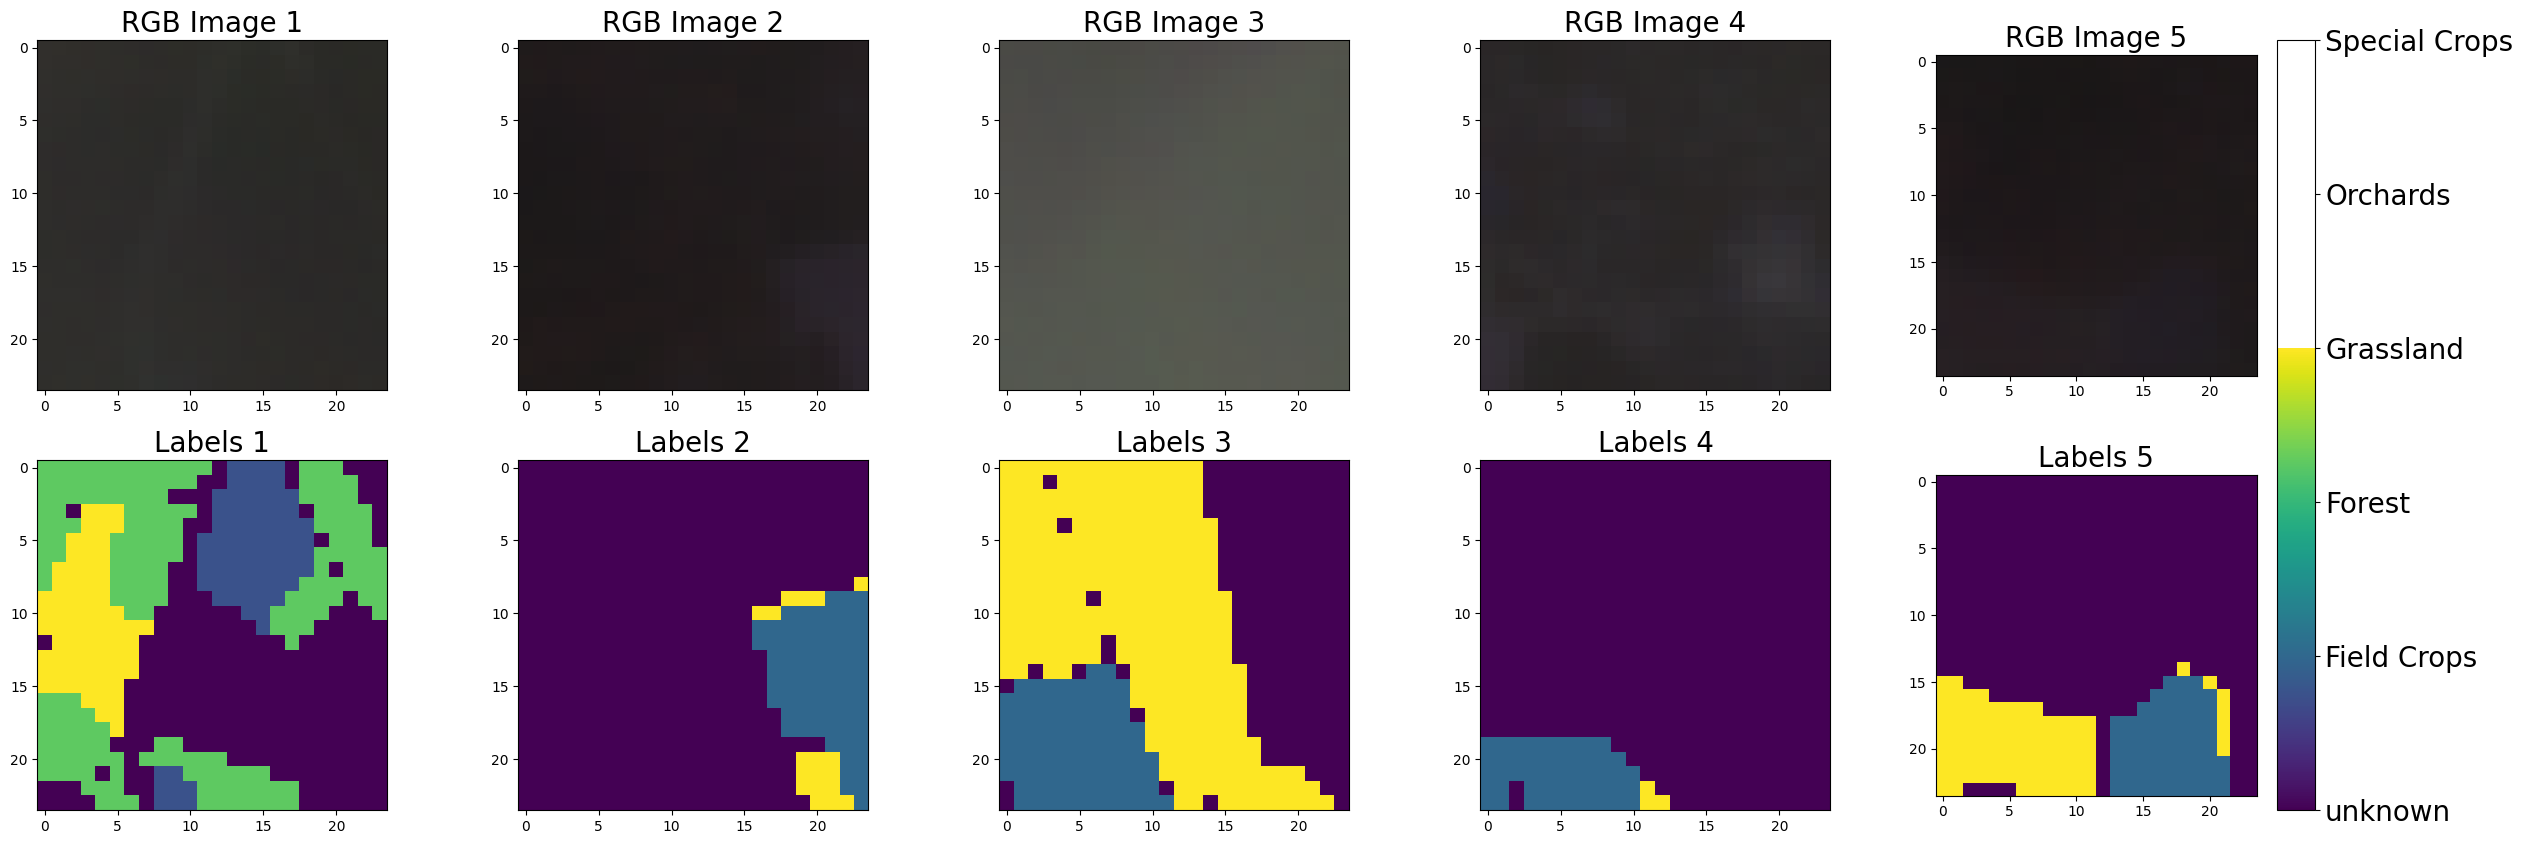

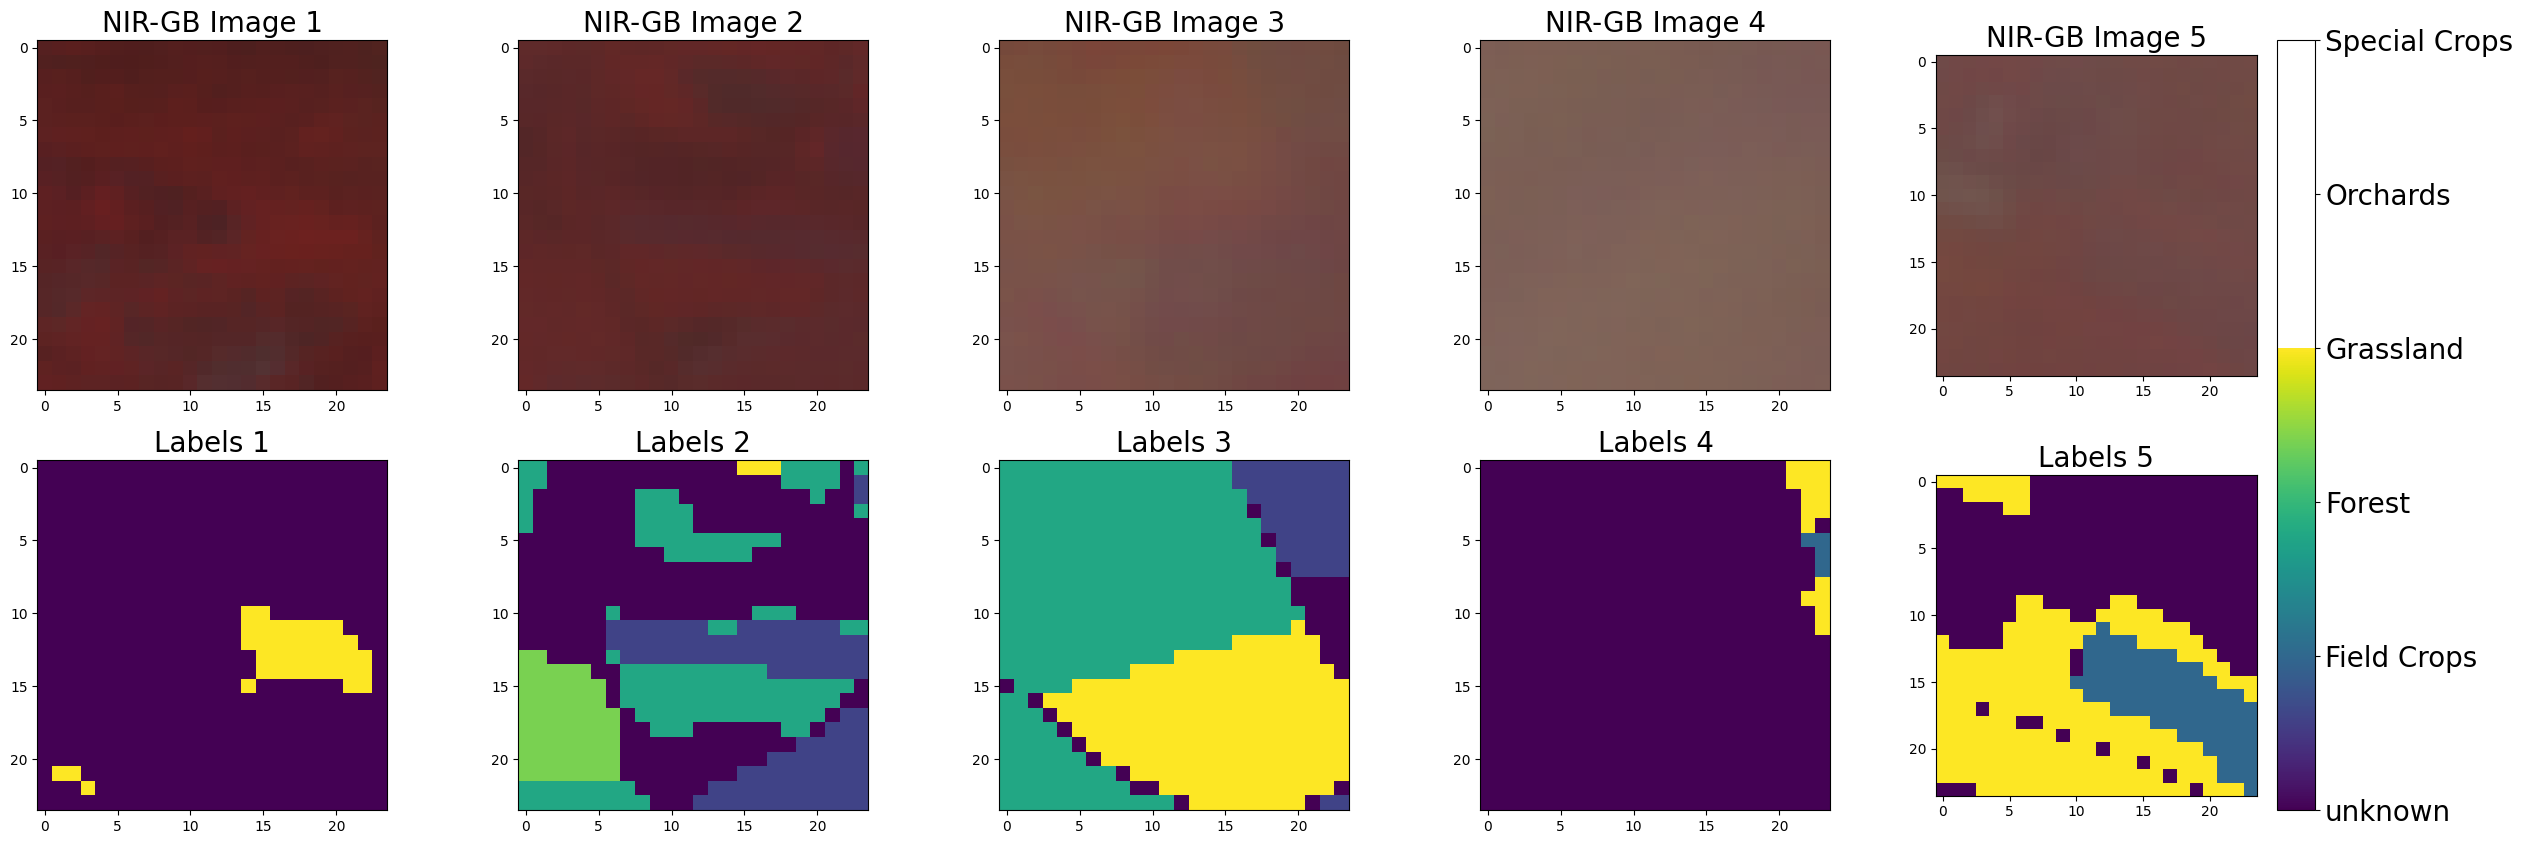

In [10]:
# Plotting RGB images and corresponding labels for 5 random samples
fig, axs = plt.subplots(2, 5, figsize=(30, 10))

# Mapping numeric labels to their corresponding class names
label_mapping = {i: v for i, v in enumerate(value_labels_level_1)}

# Plot 5 random samples
for i in range(0, 5):
    random_index = np.random.randint(0, len(input_train))
    rgb_image = input_train[random_index]
    labels = target_train[random_index]
    rgb_channels = rgb_image[:, [1, 2, 3], :, :]  # Selecting RGB channels
    # Ensure the tensor is in the range [0, 1]
    rgb_channels = torch.clamp(rgb_channels, 0, 1)
    # Plot RGB image
    rgb_image_to_plot = rgb_channels.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    axs[0, i].imshow(rgb_image_to_plot, cmap='gray')
    axs[0, i].set_title(f'RGB Image {i + 1}', fontsize=20)

    # Plotting labels
    img = axs[1, i].imshow(labels.cpu().detach().numpy(), cmap='viridis')
    axs[1, i].set_title(f'Labels {i + 1}', fontsize=20)

# Add colorbar for the entire figure
cbar = fig.colorbar(img, ax=axs[:, -1])
cbar.set_ticks(list(label_mapping.keys()))
cbar.set_ticklabels(list(label_mapping.values()), fontsize=20)

# Show the plots
plt.show()

# Plotting RGB images and corresponding labels for 5 more random samples
fig, axs = plt.subplots(2, 5, figsize=(30, 10))

# Mapping numeric labels to their corresponding class names
label_mapping = {i: v for i, v in enumerate(value_labels_level_1)}

# Plot 5 random samples
for i in range(0, 5):
    random_index = np.random.randint(0, len(input_train))
    rgb_image = input_train[random_index]
    labels = target_train[random_index]
    # Selecting other NIR-GB channels
    rgb_channels = rgb_image[:, [0, 2, 3], :, :]
    # Ensure the tensor is in the range [0, 1]
    rgb_channels = torch.clamp(rgb_channels, 0, 1)
    # Plot RGB image
    rgb_image_to_plot = rgb_channels.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    axs[0, i].imshow(rgb_image_to_plot, cmap='gray')
    axs[0, i].set_title(f'NIR-GB Image {i + 1}', fontsize=20)

    # Plotting labels
    img = axs[1, i].imshow(labels.cpu().detach().numpy(), cmap='viridis')
    axs[1, i].set_title(f'Labels {i + 1}', fontsize=20)

# Add colorbar for the entire figure
cbar = fig.colorbar(img, ax=axs[:, -1])
cbar.set_ticks(list(label_mapping.keys()))
cbar.set_ticklabels(list(label_mapping.values()), fontsize=20)

# Show the plots
plt.show()


Discerning structures in satellite images proves to be a formidable task for humans, whether examining RGB or NIR-GB representations. The complexity of the imagery necessitates the development of models capable of not only recognizing structures but also discerning patterns within different classes. It is imperative for these models to possess the ability to learn and adapt to the intricacies inherent in the diverse visual information present in the satellite data.

## Field Characteristics

### Field Area Distribution
The code snippet analyzes the distribution of field areas in the dataset. It first extracts unique field values and their counts, removes the count corresponding to 0 (representing unknown labeled fields), and then plots two histograms side by side. One histogram displays the overall field area distribution, while the other focuses on areas less than or equal to 500 pixels.


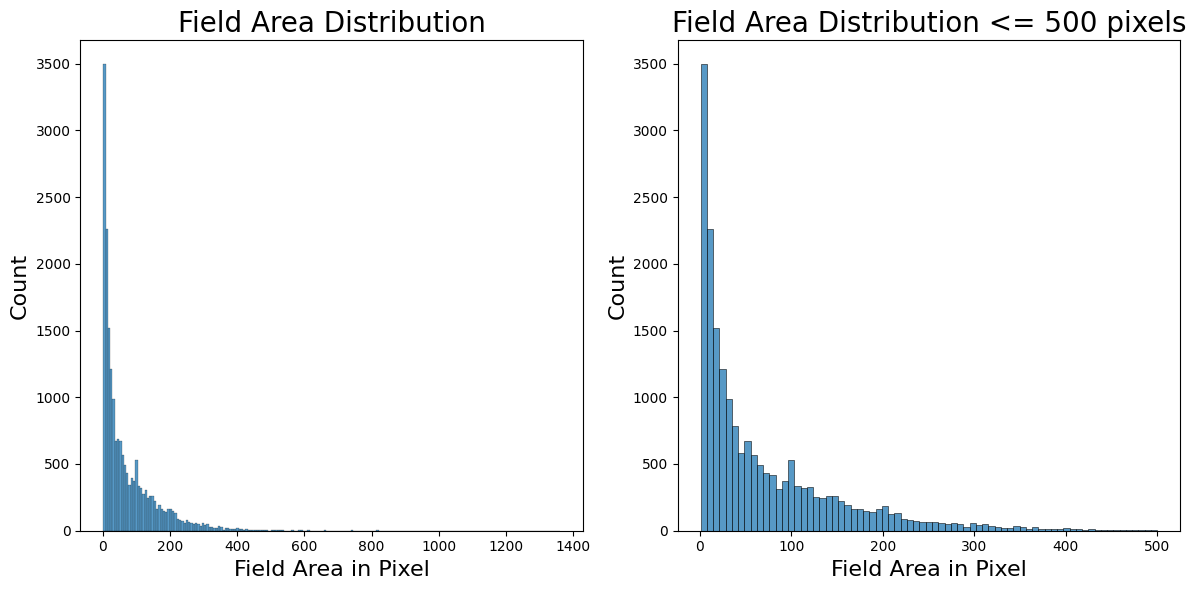

In [11]:
# Extract unique values and their counts from the flattened 'field_instance_train' tensor
unique_fields_tile, fields_counts_tile = field_instance_train.flatten().unique(
    return_counts=True)

# Remove the count corresponding to 0 (assuming 0 represents an invalid or empty field)
unique_fields_tile = unique_fields_tile[1:]
fields_counts_tile = fields_counts_tile[1:]

# Sort the unique field values based on their counts in descending order
sorted_indices = torch.argsort(fields_counts_tile, descending=True)
unique_fields_tile = unique_fields_tile[sorted_indices]
fields_counts_tile = fields_counts_tile[sorted_indices]

# Create subplots for two histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for field areas <= 500 pixels
sns.histplot(fields_counts_tile[fields_counts_tile <= 500], ax=axes[1])
axes[1].set_title('Field Area Distribution <= 500 pixels', fontsize=20)
axes[1].set_xlabel('Field Area in Pixel', fontsize=16)
axes[1].set_ylabel('Count', fontsize=16)

# Plot histogram for the overall field area distribution
sns.histplot(fields_counts_tile, ax=axes[0])
axes[0].set_title('Field Area Distribution', fontsize=20)
axes[0].set_xlabel('Field Area in Pixel', fontsize=16)
axes[0].set_ylabel('Count', fontsize=16)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


There are a lot of small fields in the dataset. The very small ones could also be some streets or houses which only have a very limited of number of pixels. One pixel represents 100m2, so it is not suprisingly that there are a lot of "small" fields.

### Field Visualization with Field and Crop Labels

This code generates visualizations of satellite imagery along with corresponding field and crop labels for selected fields. Two sets of visualizations are created, one for RGB imagery and another for NIR-GB imagery, showcasing the field and crop labels.

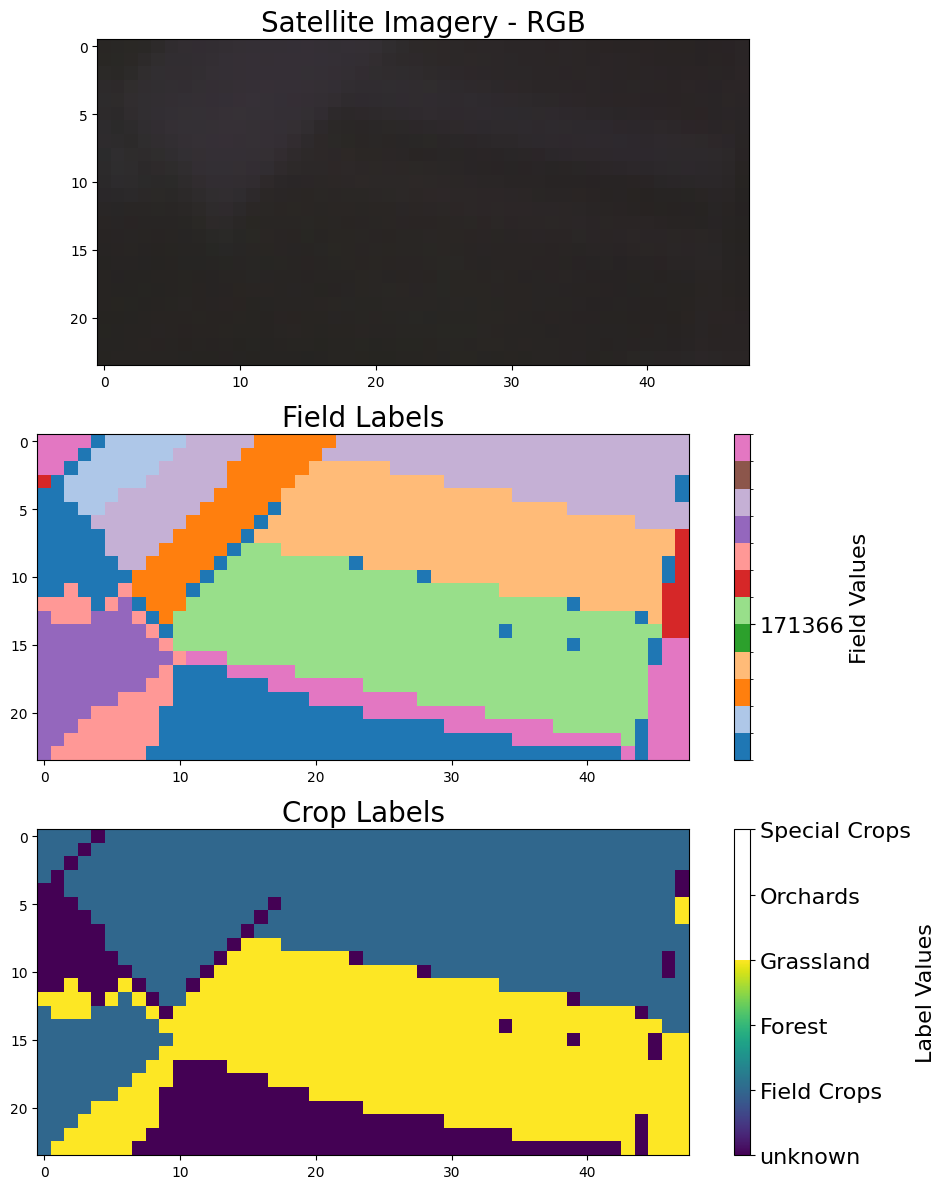

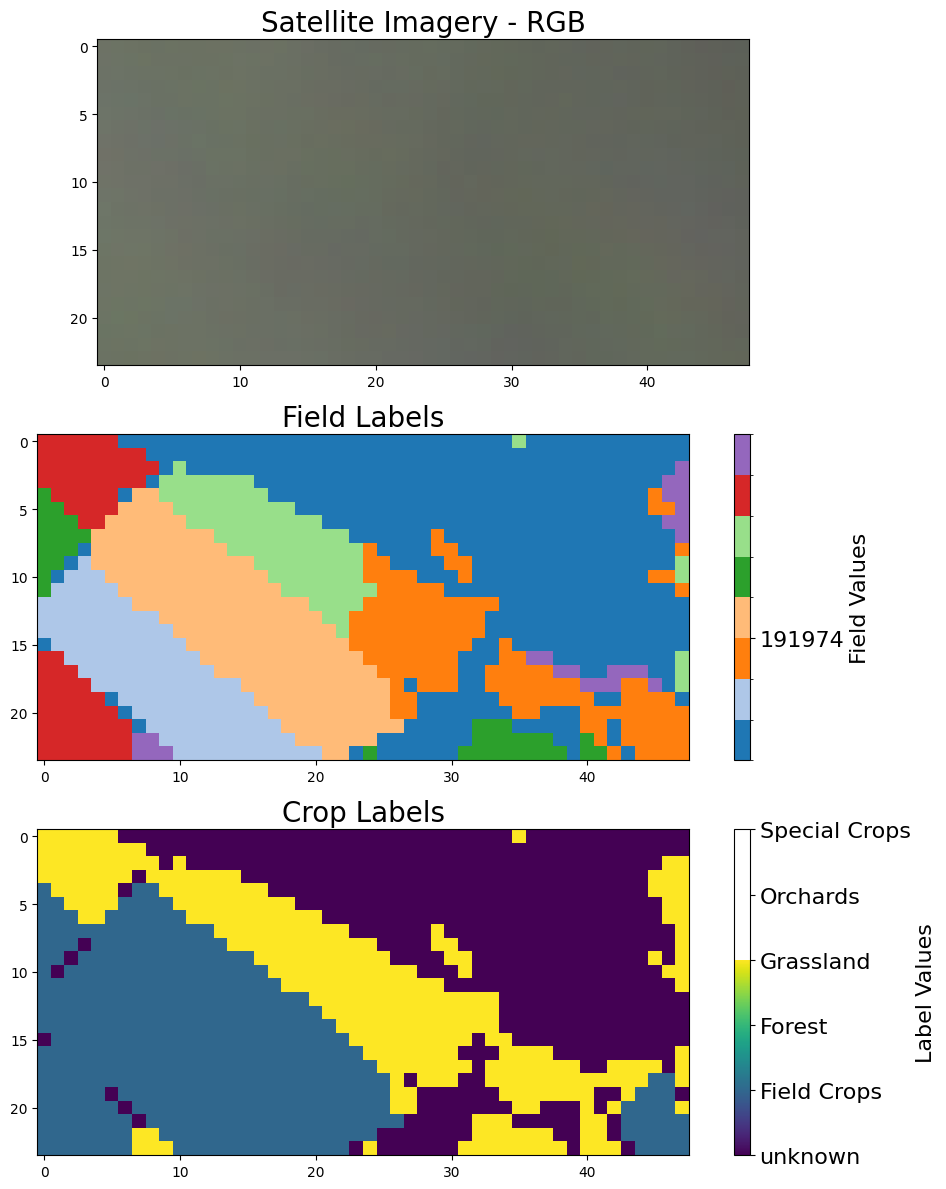

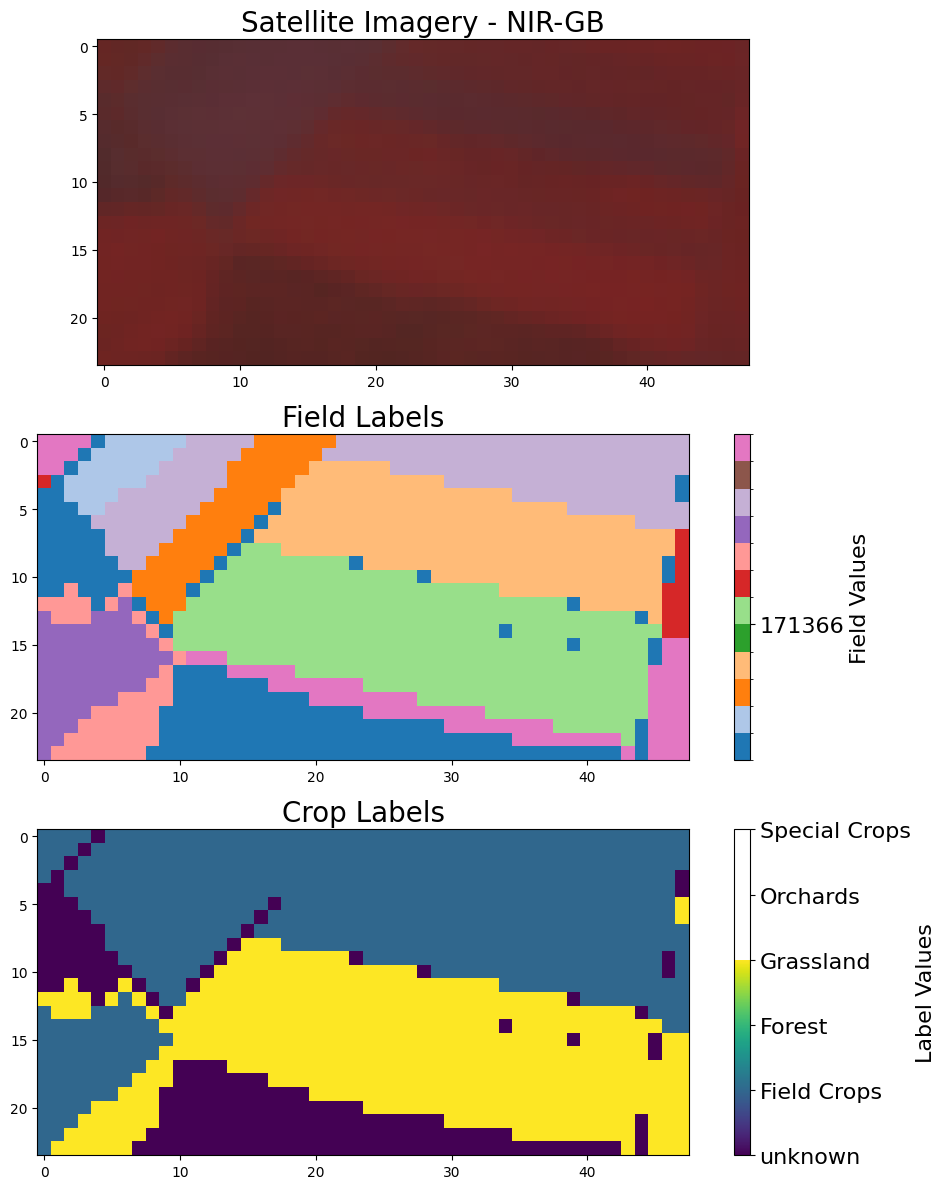

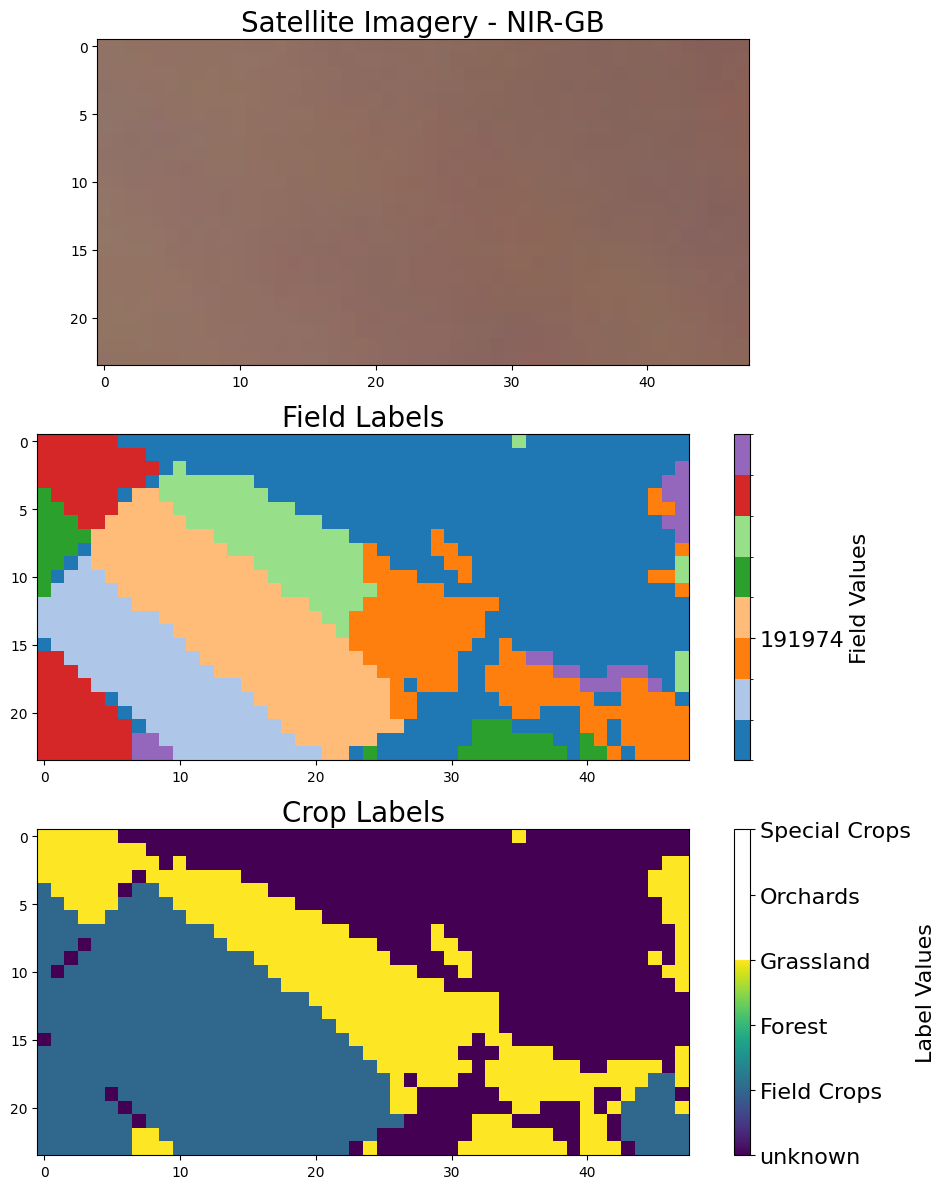

In [12]:
# get some field instances
fields = [unique_fields_tile[i].numpy().max() for i in [600, 2000]]

for field in fields:
    tensor_for_data = []
    tensor_for_field = []
    tensor_for_target = []
    for i in range(target_train.size(0)):
        has_value_field = torch.any(field_instance_train[i] == field).item()
        if has_value_field:
            tensor_for_data.append(input_train[i, :, 1:4, :, :])
            tensor_for_field.append(field_instance_train[i])
            tensor_for_target.append(target_train[i])

    stacked_tensor_field = torch.cat(tensor_for_field, dim=1)
    stacked_tensor_target = torch.cat(tensor_for_target, dim=1)
    tensor_for_data = torch.stack(tensor_for_data)
    tensor_for_data = torch.clamp(tensor_for_data, 0, 1)
    stacked_image = torch.cat([tensor_for_data[i]
                              for i in range(tensor_for_data.size(0))], dim=3)

    stacked_image = stacked_image.squeeze().permute(1, 2, 0).numpy()
    label_mapping_fields_field = {field: field}
    label_mapping_fields = {v: v for i, v in enumerate(
        tensor_for_field[0].unique().numpy())}

    # Plot the image
    plt.figure(figsize=(10, 12))  # Adjust the width and height as needed
    # Create a gridspec layout
    gs = gridspec.GridSpec(3, 1, width_ratios=[4], height_ratios=[1, 1, 1])

    # Plot the image
    ax0 = plt.subplot(gs[0])
    im0 = ax0.imshow(stacked_image)
    ax0.set_title('Satellite Imagery - RGB', fontsize=20)

    # Extract unique category values
    unique_categories = sorted(list(set(label_mapping_fields.values())))
    # Define colors for each category
    category_colors = plt.cm.tab20.colors[:len(unique_categories)]
    # Create a colormap with specified colors
    cmap = colors.ListedColormap(category_colors)
    # Define bounds and norm
    bounds = unique_categories
    norm = colors.BoundaryNorm(bounds, cmap.N)
    # Plot the pixel labels
    ax1 = plt.subplot(gs[1])
    im1 = ax1.imshow(stacked_tensor_field, cmap=cmap,
                     norm=norm, origin='upper')
    ax1.set_title('Field Labels', fontsize=20)
    # make a color bar
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Field Values', fontsize=16)
    cbar1.set_ticks(list(label_mapping_fields_field.keys()))
    cbar1.set_ticklabels(
        list(label_mapping_fields_field.values()), fontsize=16)

    # Plot the pixel labels
    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(stacked_tensor_target)
    ax2.set_title('Crop Labels', fontsize=20)
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Label Values', fontsize=16)
    cbar2.set_ticks(list(label_mapping.keys()))
    cbar2.set_ticklabels(list(label_mapping.values()), fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

for field in fields:
    tensor_for_data = []
    tensor_for_field = []
    tensor_for_target = []
    for i in range(target_train.size(0)):
        has_value_field = torch.any(field_instance_train[i] == field).item()
        if has_value_field:
            tensor_for_data.append(input_train[i, :, [0, 2, 3], :, :])
            tensor_for_field.append(field_instance_train[i])
            tensor_for_target.append(target_train[i])

    stacked_tensor_field = torch.cat(tensor_for_field, dim=1)
    stacked_tensor_target = torch.cat(tensor_for_target, dim=1)
    tensor_for_data = torch.stack(tensor_for_data)
    tensor_for_data = torch.clamp(tensor_for_data, 0, 1)
    stacked_image = torch.cat([tensor_for_data[i]
                              for i in range(tensor_for_data.size(0))], dim=3)

    stacked_image = stacked_image.squeeze().permute(1, 2, 0).numpy()
    label_mapping_fields_field = {field: field}
    label_mapping_fields = {v: v for i, v in enumerate(
        tensor_for_field[0].unique().numpy())}

    # Plot the image
    plt.figure(figsize=(10, 12))  # Adjust the width and height as needed
    # Create a gridspec layout
    gs = gridspec.GridSpec(3, 1, width_ratios=[4], height_ratios=[1, 1, 1])

    # Plot the image
    ax0 = plt.subplot(gs[0])
    im0 = ax0.imshow(stacked_image)
    ax0.set_title('Satellite Imagery - NIR-GB', fontsize=20)
    # cbar1 = plt.colorbar(im0, ax=ax0)
    # cbar1.set_label('RGB Values')

    # Extract unique category values
    unique_categories = sorted(list(set(label_mapping_fields.values())))
    # Define colors for each category
    category_colors = plt.cm.tab20.colors[:len(unique_categories)]
    # Create a colormap with specified colors
    cmap = colors.ListedColormap(category_colors)
    # Define bounds and norm
    bounds = unique_categories
    norm = colors.BoundaryNorm(bounds, cmap.N)
    # Plot the pixel labels
    ax1 = plt.subplot(gs[1])
    im1 = ax1.imshow(stacked_tensor_field, cmap=cmap,
                     norm=norm, origin='upper')
    ax1.set_title('Field Labels', fontsize=20)
    # make a color bar
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Field Values', fontsize=16)
    cbar1.set_ticks(list(label_mapping_fields_field.keys()))
    cbar1.set_ticklabels(
        list(label_mapping_fields_field.values()), fontsize=16)

    # Plot the pixel labels
    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(stacked_tensor_target)
    ax2.set_title('Crop Labels', fontsize=20)
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Label Values', fontsize=16)
    cbar2.set_ticks(list(label_mapping.keys()))
    cbar2.set_ticklabels(list(label_mapping.values()), fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


The four image excerpts each show two adjacent images, creating a contiguous image of 24 x 48 pixels. It is evident that adjacent fields sometimes cultivate the same crops. Furthermore, in the label excerpts, it is clear that paths or individual houses occupy only 1 pixel.

In the last excerpt, the issue of non-overlapping labels for crops and field instances is apparent. In the Crop Labels image, there is a break in the dark violet field labeled as unknown around the coordinates 32/15. However, in the labels above, the field instance is continuous. This becomes a significant problem, especially when the model includes a Field Majority, as inconsistencies can arise.

## Further Analyses

Additional analyses, such as evaluating roundness and overlapping of field instances, have not been conducted thus far. This limitation is attributed to the constraints of the ground-truth data, which do not always permit the accurate tracing of fields in their spatial dimensions. To undertake a more comprehensive and precise analysis, it is advisable to consider enhancing the quality of the ground-truth data in future endeavors.